# Previsão de renda - Projeto II

### 4 elementos importantes
- *Esse notebook*
- *Streamlit com as análises*
- *Seu Github com o projeto*
- *Vídeo no readme do github mostrando o streamlit*

## Etapa 1 CRISP - DM: Entendimento do negócio

* Objetivos do Projeto: Criar previsão de renda para análise de crédito visando a melhor distribuição do mesmo;
* Situação Atual: Não existe análise e correrlação entre a renda dos clientes e as demais variáveis contifas no banco de dados;
* Objetivos da Mineração de Dados: utilização posterior de diversas formas, como em empréstimos ou como parte numa definição de score.


## Etapa 2 Crisp-DM: Entendimento dos dados


### Dicionário de dados



| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Mês da Inclusão dos Dados                          | dd/mm/yy|
| id_cliente              |  Código do Cliente                                  | int|
| sexo                    |  Masculino ou Feminino                              | string|
| posse_de_veiculo        |  Cliente possuidor de veículo                       | Bool|
| posse_de_imovel         |  Cliente possuidor de Imóvel                        | Bool|
| qtd_filhos              |  Quantidade de filhos do cliente                    | int|
| tipo_renda              |  Origem dos rendimentos do cliente                  | string|
| educacao                |  Nível escolar do cliente                           | string|
| estado_civil            |  Estado cívil atual do cliente                      | string|
| tipo_residencia         |  Situaçlão do imóvel de residência                  | string|
| idade                   |  Idade na época da inclusão                         | int|
| tempo_emprego           |  anos de emprego                                    | float|
| qt_pessoas_residencia   |  Qunatas pessoas residem no imóvel                  | float|
| renda                   |  Renda do cliente no momento do cadastro            | float|





#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from ydata_profiling import ProfileReport

%matplotlib inline

#### Carregando os dados

In [169]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [170]:
renda = renda.drop('Unnamed: 0', axis=1)
renda.head(3)

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [171]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 1341.72it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [172]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Entendimento dos dados - Bivariadas




Realizei uma crosstab das varíveis categóricas e consegui identificar:

* 1. Homens possuem mais veículos que mulheres
* 2. Mulheres possuem mais imóveis que homens
* 3. 2/3 de quem possui imóvel, também possui veículo


In [173]:
crosstab_renda_sx_veic = pd.crosstab(renda['sexo'], renda['posse_de_veiculo'], normalize='index').round(2)
crosstab_renda_sx_veic

posse_de_veiculo,False,True
sexo,,
F,0.73,0.27
M,0.36,0.64


In [174]:
crosstab_renda_sx_imv = pd.crosstab(renda['sexo'], renda['posse_de_imovel'], normalize='index').round(2)
crosstab_renda_sx_imv

posse_de_imovel,False,True
sexo,,
F,0.30,0.70
M,0.36,0.64


In [175]:
crosstab_renda_veic_imv = pd.crosstab(renda['posse_de_veiculo'], renda['posse_de_imovel'], normalize='index').round(2)
crosstab_renda_veic_imv

posse_de_imovel,False,True
posse_de_veiculo,,
False,0.32,0.68
True,0.33,0.67


Realizei uma Matriz de Correlação das variáveis numéricas e consegui constatar que a correlação mais forte em relação à renda é o tempo de emprego.


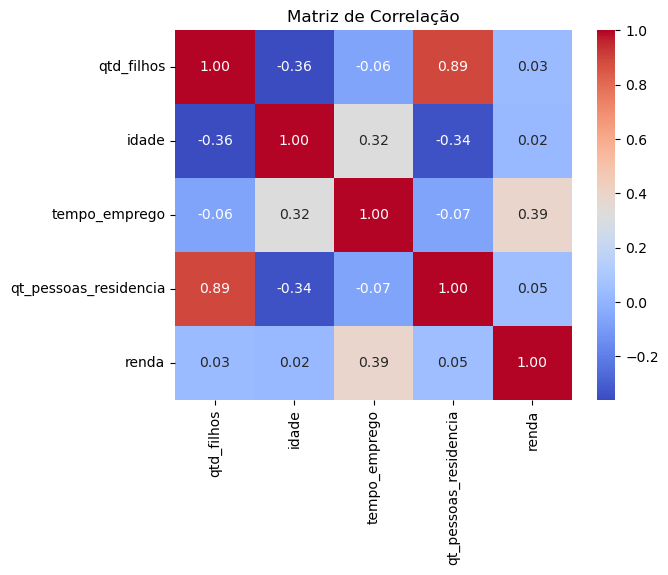

In [176]:
renda_num = renda[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]

matriz_corr = renda_num.corr()
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



Realizada 2 ações de correção:

1. Completar as linhas faltantes na coluna *tempo_emprego* com zero;
2. Dropar as colunas *data_ref* e *id_cliente* por não possuírem correlação;
3. Dropar as colunas *qtd_filhos*, *idade* e *qt_pessoas_residencia* por conta da baixa correlação.


In [177]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data_ref               15000 non-null  object 
 1   id_cliente             15000 non-null  int64  
 2   sexo                   15000 non-null  object 
 3   posse_de_veiculo       15000 non-null  bool   
 4   posse_de_imovel        15000 non-null  bool   
 5   qtd_filhos             15000 non-null  int64  
 6   tipo_renda             15000 non-null  object 
 7   educacao               15000 non-null  object 
 8   estado_civil           15000 non-null  object 
 9   tipo_residencia        15000 non-null  object 
 10  idade                  15000 non-null  int64  
 11  tempo_emprego          12427 non-null  float64
 12  qt_pessoas_residencia  15000 non-null  float64
 13  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(6)
memory usa

In [178]:
renda = renda.dropna(subset=['tempo_emprego'])

In [179]:
renda = renda.drop(['data_ref', 'id_cliente', 'qtd_filhos', 'idade', 'qt_pessoas_residencia'], axis=1)

In [180]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sexo              12427 non-null  object 
 1   posse_de_veiculo  12427 non-null  bool   
 2   posse_de_imovel   12427 non-null  bool   
 3   tipo_renda        12427 non-null  object 
 4   educacao          12427 non-null  object 
 5   estado_civil      12427 non-null  object 
 6   tipo_residencia   12427 non-null  object 
 7   tempo_emprego     12427 non-null  float64
 8   renda             12427 non-null  float64
dtypes: bool(2), float64(2), object(5)
memory usage: 801.0+ KB


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


Selecionar a Técnica de Rodagem


Utilizarei as técnicas de modelagem abaixo:

* Regressão Linear
* Random Forest Regressor
* Gradient Boosting Regressor

### Rodando o modelo


In [181]:
categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
               'educacao', 'estado_civil', 'tipo_residencia']

renda = pd.get_dummies(renda, columns=categoricas, drop_first=True)

renda.head(3)

,tempo_emprego,renda,sexo_M,posse_de_veiculo_True,posse_de_imovel_True,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Pós graduação,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,6.602740,8060.34,False,False,True,False,True,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,7.183562,1852.15,True,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,0.838356,2253.89,False,True,True,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [182]:
y = renda['renda']
X = renda.drop(columns=['renda'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (9941, 21)
X_test: (2486, 21)
y_train: (9941,)
y_test: (2486,)


In [ ]:
tree_depth_8 = DecisionTreeRegressor(max_depth=8, random_state=62)
tree_depth_4 = DecisionTreeRegressor(max_depth=4, random_state=62)

In [ ]:
tree_depth_8.fit(X_train, y_train)
tree_depth_4.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=62)

In [195]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"RMSE Treino: {rmse_train:.2f} | Teste: {rmse_test:.2f}")
    print(f"R² Treino: {r2_train:.2f} | Teste: {r2_test:.2f}")

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    print(f"RMSE Validação Cruzada: {cv_rmse:.2f}")

In [196]:
print("Árvore profundidade 8:")
evaluate_model(tree_depth_8, X_train, X_test, y_train, y_test)

Árvore profundidade 8:
RMSE Treino: 5611.06 | Teste: 6479.89
R² Treino: 0.63 | Teste: 0.27
RMSE Validação Cruzada: 7946.90


In [ ]:
print("\nÁrvore profundidade 4:")
evaluate_model(tree_depth_4, X_train, X_test, y_train, y_test)


Árvore profundidade 4:
RMSE Treino: 6666.93 | Teste: 6057.01
R² Treino: 0.47 | Teste: 0.37
RMSE Validação Cruzada: 7715.20


In [ ]:
path = tree_depth_4.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([      0.        ,   26111.80862087,   32519.75007836,
          89576.11450307,  119307.37820939,  186902.19418417,
         848962.86675177, 1054342.98790939, 1376738.3217539 ,
        2186268.77830701, 2436431.08072482, 2883977.35961068,
        9541991.84852323]),
 'impurities': array([44447971.14307445, 44474082.95169532, 44506602.70177369,
        44596178.81627677, 44715486.19448616, 44902388.38867033,
        45751351.2554221 , 46805694.24333149, 48182432.5650854 ,
        50368701.34339241, 52805132.42411723, 55689109.78372791,
        84315085.3292976 ])}

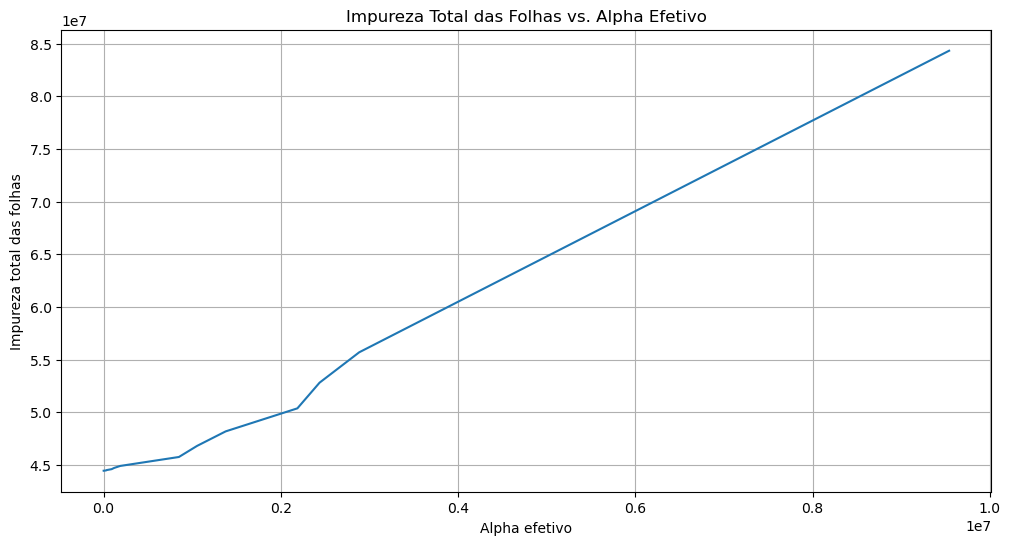

In [199]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(12,6))
plt.plot(ccp_alphas, impurities)
plt.xlabel('Alpha efetivo')
plt.ylabel('Impureza total das folhas')
plt.title('Impureza Total das Folhas vs. Alpha Efetivo')
plt.grid(True)
plt.show()

In [200]:
optimal_alpha = ccp_alphas[np.argmin(np.diff(impurities)) + 1]

pruned_tree = DecisionTreeRegressor(ccp_alpha=optimal_alpha, random_state=42)
pruned_tree.fit(X_train, y_train)

print("\nÁrvore com poda (alpha ótimo):")
evaluate_model(pruned_tree, X_train, X_test, y_train, y_test)


Árvore com poda (alpha ótimo):
RMSE Treino: 4883.09 | Teste: 6253.08
R² Treino: 0.72 | Teste: 0.32
RMSE Validação Cruzada: 7822.75


## Etapa 5 Crisp-DM: Avaliação dos resultados


Após a avaliação, é possível eleger como variáveis mais importates:

1. tempo_emprego
2. idade
3. tipo_renda

Concluí que o desempenho do modelo seria adequado para o uso em decisões de crédito.


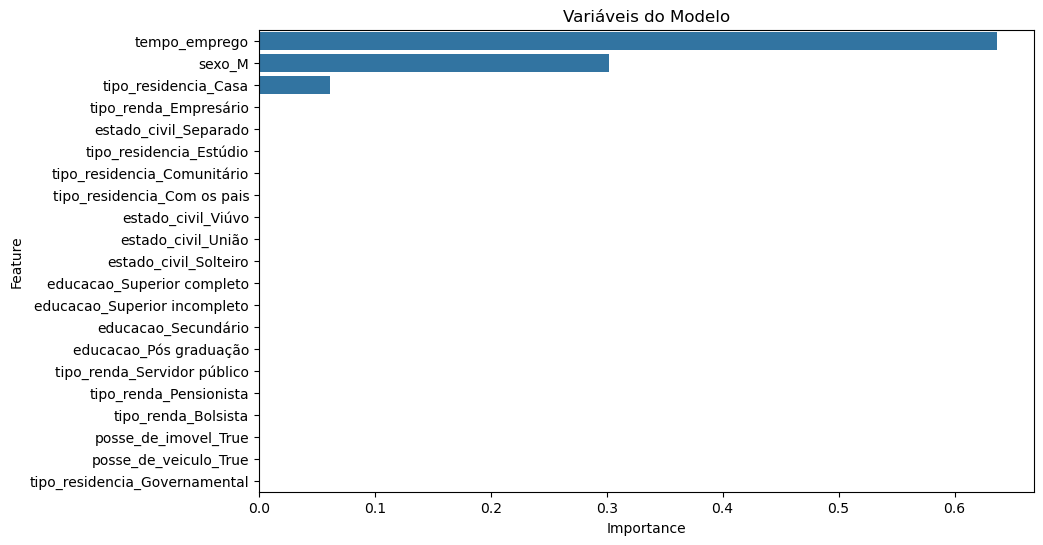

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree_depth_4.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Variáveis do Modelo')
plt.show()

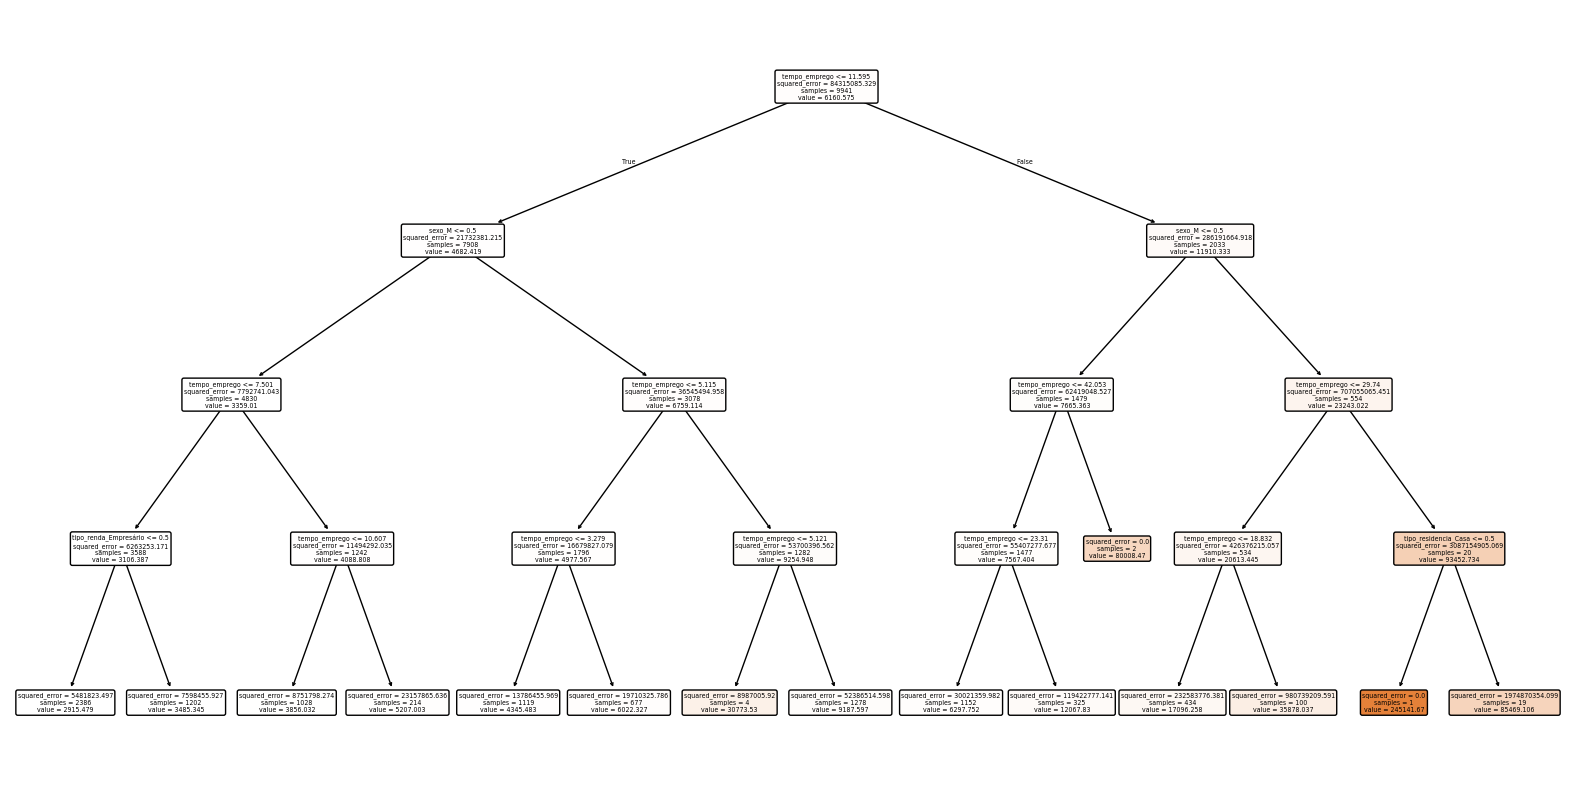

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(tree_depth_4, 
          feature_names=X.columns,  
          filled=True, 
          rounded=True)
plt.show()

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

Estratégia de Implantação

* API: Criar um serviço web que recebe dados do cliente e retorna a previsão de renda
* Integração: Conectar o modelo ao atual sistema de análise de crédito
* Monitoramento: Dashboard para acompanhar o desempenho do modelo